# Face Generation

In this project, you'll define and train a Generative Adverserial network of your own creation on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **defining new architectures training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset has higher resolution images than datasets you have previously worked with (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed-celeba-small/`.

In [37]:
# run this once to unzip the file
# !unzip processed-celeba-small.zip

In [38]:
import warnings
warnings.filterwarnings('ignore')

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import tests
import random

from datetime import datetime
from glob import glob
from PIL import Image
from typing import Tuple, Callable, Dict

import torch
import torch.optim as optim
import torch.nn as nn
from torch.nn import Module
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

In [40]:
data_dir = 'processed_celeba_small/celeba/'

## Data pipeline

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA dataset and contains roughly 30,000 images. 

Your first task consists in building the dataloader. To do so, you need to do the following:
* implement the get_transforms function
* create a custom Dataset class that reads the CelebA data

### Exercise: implement the get_transforms function

The `get_transforms` function should output a [`torchvision.transforms.Compose`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose) of different transformations. You have two constraints:
* the function takes a tuple of size as input and should **resize the images** to the input size
* the output images should have values **ranging from -1 to 1**

In [41]:
def get_transforms(size: Tuple[int, int]) -> Callable:
    """ Transforms to apply to the image."""
    transforms = [Resize(size), ToTensor(), Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))]
    
    return Compose(transforms)

### Exercise: implement the DatasetDirectory class


The `DatasetDirectory` class is a torch Dataset that reads from the above data directory. The `__getitem__` method should output a transformed tensor and the `__len__` method should output the number of files in our dataset. You can look at [this custom dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) for ideas. 

In [42]:
class DatasetDirectory(Dataset):
    """
    A custom dataset class that loads images from folder.
    args:
    - directory: location of the images
    - transform: transform function to apply to the images
    - extension: file format
    """
    def __init__(self, directory: str, transforms: Callable = None, extension: str = '.jpg'):
        # implement the init method
        self.directory = directory
        self.transforms = transforms
        self.extension = extension
        
        str_wcard = self.directory + '*' + self.extension
        self.str_wcard = str_wcard

    def __len__(self) -> int:
        """ returns the number of items in the dataset """
        # return the number of elements in the dataset
        num_images = len(glob(self.str_wcard))

        return num_images

    def __getitem__(self, index: int) -> torch.Tensor:
        """ load an image and apply transformation """
        # return the index-element of the dataset after applying transformation
        file_list = glob(self.str_wcard)
        img = Image.open(file_list[index])
        
        return self.transforms(img)

In [43]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

# run this cell to verify your dataset implementation
size = (64, 64)
dataset = DatasetDirectory(data_dir, get_transforms(size))
print("Dataset length = {}".format(len(dataset)))
tests.check_dataset_outputs(dataset)

Dataset length = 32600
Congrats, your dataset implementation passed all the tests


In [44]:
num_test_images = 10
for i in range(num_test_images):
    idx = random.randrange(len(dataset))
    img = dataset[idx]
    print("image#: {} | Min: {} | Max: {}".format(idx, img.min(), img.max()))

image#: 1977 | Min: -0.8745098114013672 | Max: 1.0
image#: 12666 | Min: -0.929411768913269 | Max: 0.9215686321258545
image#: 17393 | Min: -1.0 | Max: 0.8666666746139526
image#: 15949 | Min: -1.0 | Max: 1.0
image#: 3767 | Min: -0.9450980424880981 | Max: 0.6705882549285889
image#: 12766 | Min: -1.0 | Max: 1.0
image#: 12770 | Min: -1.0 | Max: 0.9686274528503418
image#: 2549 | Min: -1.0 | Max: 1.0
image#: 11538 | Min: -0.9843137264251709 | Max: 1.0
image#: 11896 | Min: -0.9764705896377563 | Max: 0.8901960849761963


The functions below will help you visualize images from the dataset.

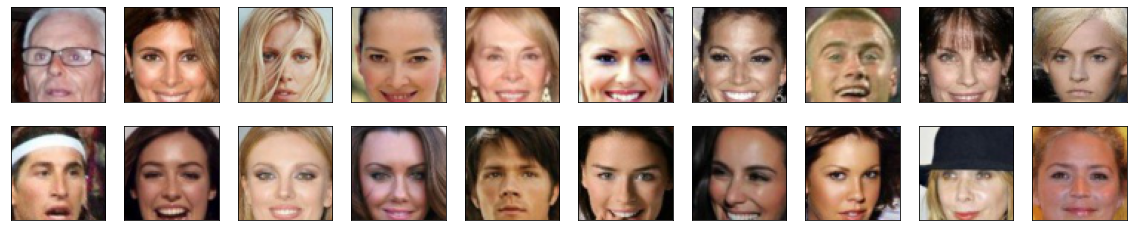

In [45]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def denormalize(images):
    """Transform images from [-1.0, 1.0] to [0, 255] and cast them to uint8."""
    return ((images + 1.) / 2. * 255).astype(np.uint8)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    img = dataset[idx].numpy()
    img = np.transpose(img, (1, 2, 0))
    img = denormalize(img)
    ax.imshow(img)

## Model implementation

As you know, a GAN is comprised of two adversarial networks, a discriminator and a generator. Now that we have a working data pipeline, we need to implement the discriminator and the generator. 

Feel free to implement any additional class or function.

### Exercise: Create the discriminator

The discriminator's job is to score real and fake images. You have two constraints here:
* the discriminator takes as input a **batch of 64x64x3 images**
* the output should be a single value (=score)

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips
* To scale down from the input image, you can either use `Conv2d` layers with the correct hyperparameters or Pooling layers.
* If you plan on using gradient penalty, do not use Batch Normalization layers in the discriminator.

In [46]:
def ConvBlock(in_channels: int, out_channels: int, in_spatial_dim: Tuple[int, int], kernel_size: int, batch_norm: bool = True, layer_norm: bool = False):
    """
    A convolutional block is made of 3 layers: Conv -> BatchNorm -> Activation.
    args:
    - in_channels: number of channels in the input to the conv layer
    - out_channels: number of filters in the conv layer
    - in_spatial_dim: size of input image
    - kernel_size: filter dimension of the conv layer
    - batch_norm: whether to use batch norm or not
    - layer_norm: whether to use layer norm or not
    """
    layers = []
    
    conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=2, padding=1, bias=False)
    layers.append(conv)

    if batch_norm:
        bn = nn.BatchNorm2d(out_channels)
        layers.append(bn)

    if layer_norm:
        # out_spatial_dim = ((in_spatial_dim + 2*padding - kernel_size) // stride) + 1
        out_spatial_dim = ((np.asarray(in_spatial_dim) + 2 - kernel_size) // 2) + 1
        ln = nn.LayerNorm([out_channels, out_spatial_dim[0], out_spatial_dim[1]], bias = False)
        layers.append(ln)

    activation = nn.LeakyReLU(0.2)
    layers.append(activation)
    
    return nn.Sequential(*layers)

In [47]:
class Discriminator(Module):
    def __init__(self, conv_dim: int = 64, size: Tuple[int, int] = (64,64), use_batch_norm: bool = True, use_layer_norm: bool = False):
        super(Discriminator, self).__init__()
        
        self.conv1 = ConvBlock(in_channels=3, out_channels=conv_dim, in_spatial_dim=size, kernel_size=4, batch_norm=False, layer_norm=False) # 3x64x64 --> conv_dimx32x32. First layer, no batch_norm or layer_norm.
        self.conv2 = ConvBlock(in_channels=conv_dim, out_channels=conv_dim*2, in_spatial_dim=tuple(np.divide(size,2).astype(int)), kernel_size=4, batch_norm=use_batch_norm, layer_norm=use_layer_norm) # conv_dimx32x32 --> (conv_dim*2)x16x16
        self.conv3 = ConvBlock(in_channels=conv_dim*2, out_channels=conv_dim*4, in_spatial_dim=tuple(np.divide(size,4).astype(int)), kernel_size=4, batch_norm=use_batch_norm, layer_norm=use_layer_norm) # (conv_dim*2)x16x16 --> (conv_dim*4)x8x8
        self.conv4 = ConvBlock(in_channels=conv_dim*4, out_channels=conv_dim*8, in_spatial_dim=tuple(np.divide(size,8).astype(int)), kernel_size=4, batch_norm=use_batch_norm, layer_norm=use_layer_norm) # (conv_dim*4)x8x8 --> (conv_dim*8)x4x4
        
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(conv_dim*8*4*4, 1) # final, fully-connected layer

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        x = self.fc(x)

        return x

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Use GPU if available
print("Device = {}".format(device))

Device = cuda


In [49]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

# run this cell to check your discriminator implementation
discriminator = Discriminator(conv_dim=64, size=size, use_batch_norm=True, use_layer_norm=False).to(device)
print(discriminator)
tests.check_discriminator(discriminator)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=8192, out_features=1, bias

### Exercise: create the generator

The generator's job creates the "fake images" and learns the dataset distribution. You have three constraints here:
* the generator takes as input a vector of dimension `[batch_size, latent_dimension, 1, 1]`
* the generator must outputs **64x64x3 images**

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips:
* to scale up from the latent vector input, you can use `ConvTranspose2d` layers
* as often with Gan, **Batch Normalization** helps with training

In [50]:
def DeconvBlock(in_channels: int, out_channels: int, in_spatial_dim: Tuple[int, int], kernel_size: int, stride: int, padding: int, batch_norm: bool = True, layer_norm: bool = False):
    """
    A "de-convolutional" block is made of 3 layers: ConvTranspose -> BatchNorm -> Activation.
    args:
    - in_channels: number of channels in the input to the conv layer
    - out_channels: number of filters in the conv layer
    - in_spatial_dim: size of input image
    - kernel_size: filter dimension of the conv layer
    - stride: stride of the conv layer
    - padding: padding of the conv layer
    - batch_norm: whether to use batch norm or not
    - layer_norm: whether to use layer norm or not
    """
    layers = []
    
    deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False)
    layers.append(deconv)

    if batch_norm:
        bn = nn.BatchNorm2d(out_channels)
        layers.append(bn)
    
    if layer_norm:
        out_spatial_dim = (np.asarray(in_spatial_dim) - 1)*stride - 2*padding + kernel_size
        ln = nn.LayerNorm([out_channels, out_spatial_dim[0], out_spatial_dim[1]], bias = False)
        layers.append(ln)
    
    return nn.Sequential(*layers)

In [51]:
class Generator(Module):
    def __init__(self, latent_dim: int = 128, conv_dim: int = 64, use_batch_norm: bool = True, use_layer_norm: bool = False):
        super(Generator, self).__init__()
        
        self.conv_dim = conv_dim
        
        self.fc = nn.Linear(latent_dim, conv_dim*8*4*4) # conv_dim*8*4*4: same as final output size of discriminator
        
        in_spatial_dim_init = (4,4)
        self.deconv1 = DeconvBlock(in_channels=conv_dim*8, out_channels=conv_dim*4, in_spatial_dim=in_spatial_dim_init, kernel_size=4, stride=2, padding=1, batch_norm=use_batch_norm, layer_norm=use_layer_norm) # (conv_dim*8)x4x4 --> (conv_dim*4)x8x8
        self.deconv2 = DeconvBlock(in_channels=conv_dim*4, out_channels=conv_dim*2, in_spatial_dim=tuple(np.multiply(in_spatial_dim_init,2).astype(int)), kernel_size=4, stride=2, padding=1, batch_norm=use_batch_norm, layer_norm=use_layer_norm) # (conv_dim*4)x8x8 --> (conv_dim*2)x16x16
        self.deconv3 = DeconvBlock(in_channels=conv_dim*2, out_channels=conv_dim, in_spatial_dim=tuple(np.multiply(in_spatial_dim_init,4).astype(int)), kernel_size=4, stride=2, padding=1, batch_norm=use_batch_norm, layer_norm=use_layer_norm) # (conv_dim*2)x16x16 --> conv_dimx32x32
        self.deconv4 = DeconvBlock(in_channels=conv_dim, out_channels=3, in_spatial_dim=tuple(np.multiply(in_spatial_dim_init,8).astype(int)), kernel_size=4, stride=2, padding=1, batch_norm=False, layer_norm=False) # conv_dimx32x32 --> 3x64x64. Last layer, no batch_norm or layer_norm.
        
        self.activation = nn.ReLU()
        self.last_activation = nn.Tanh()

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, self.conv_dim*8, 4, 4) # re-shape as (batch_size, depth, 4, 4)
        x = self.activation(self.deconv1(x))
        x = self.activation(self.deconv2(x))
        x = self.activation(self.deconv3(x))
        x = self.last_activation(self.deconv4(x))

        return x

In [52]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

# run this cell to verify your generator implementation
generator = Generator(latent_dim=128, conv_dim=64, use_batch_norm=True, use_layer_norm=False).to(device)
print(generator)
tests.check_generator(generator, latent_dim=128)

Generator(
  (fc): Linear(in_features=128, out_features=8192, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv4): Sequential(
    (0): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (activation): ReLU()
  (last_activation): Tanh()
)
Congrats, your generator implementation passed all the tests


## Optimizer

In the following section, we create the optimizers for the generator and discriminator. You may want to experiment with different optimizers, learning rates and other hyperparameters as they tend to impact the output quality.

### Exercise: implement the optimizers

In [53]:
# Optimizer parameters
learning_rate_gen = 0.0002
learning_rate_disc = 0.0002
beta1 = 0.5   # reduce from 0.9 for GAN stability
beta2 = 0.999   # default

In [54]:
def create_optimizers(generator: Module, discriminator: Module):
    """ This function should return the optimizers of the generator and the discriminator """
    
    g_optimizer = optim.Adam(generator.parameters(), learning_rate_gen, [beta1, beta2])
    d_optimizer = optim.Adam(discriminator.parameters(), learning_rate_disc, [beta1, beta2])
    
    return g_optimizer, d_optimizer

## Losses implementation

In this section, we are going to implement the loss function for the generator and the discriminator. You can and should experiment with different loss function.

Some tips:
* You can choose the commonly used the binary cross entropy loss or select other losses we have discovered in the course, such as the Wasserstein distance.
* You may want to implement a gradient penalty function as discussed in the course. It is not required and the code will work whether you implement it or not.

In [55]:
def logits_loss(logits, real_or_fake='real'):
    batch_size = logits.size(0)
    
    if(real_or_fake == 'real'):
        labels = torch.ones(batch_size) * 0.9 # smooth real labels by 0.9
    elif(real_or_fake == 'fake'):
        labels = torch.zeros(batch_size) # fake labels = 0
    
    labels = labels.to(device)
    
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(logits.squeeze(), labels)
    
    return loss

In [56]:
def wasserstein_loss(real_logits, fake_logits, module_type):
    """
    Wasserstein Loss
    
    args:
    - real_logits: vector of logits outputed by the discriminator with a real input image
    - fake_logits: vector of logits outputed by the discriminator with a fake input image 
    """

    if(module_type == 'discriminator'):
        real_loss = -real_logits.mean()
        fake_loss = fake_logits.mean()
        total_loss = real_loss + fake_loss
    elif(module_type == 'generator'):
        fake_loss = -fake_logits.mean()
        total_loss = fake_loss
    
    return total_loss

### Exercise: implement the generator loss

The generator's goal is to get the discriminator to think its generated images (= "fake" images) are real.

In [57]:
def generator_loss(fake_logits, loss_type):
    """ Generator loss, takes the fake scores as inputs. """
    
    if(loss_type == 'bce'):
        loss = logits_loss(fake_logits, real_or_fake='real')
    elif(loss_type == 'wasserstein'):
        loss = wasserstein_loss(None, fake_logits, 'generator')

    return loss

### Exercise: implement the discriminator loss

We want the discriminator to give high scores to real images and low scores to fake ones and the discriminator loss should reflect that.

In [58]:
def discriminator_loss(real_logits, fake_logits, gp, loss_type):
    """ Discriminator loss, takes the fake and real logits as inputs. """
    
    if(loss_type == 'bce'):
        loss = logits_loss(real_logits, real_or_fake='real') + logits_loss(fake_logits, real_or_fake='fake') + lambda_p*gp
    elif(loss_type == 'wasserstein'):
        loss = wasserstein_loss(real_logits, fake_logits, 'discriminator') + lambda_p*gp
    
    return loss

### Exercise (Optional): Implement the gradient Penalty

In the course, we discussed the importance of gradient penalty in training certain types of Gans. Implementing this function is not required and depends on some of the design decision you made (discriminator architecture, loss functions).

In [59]:
lambda_p = 10 # lambda for GP

In [60]:
def gradient_penalty(real_sample, fake_sample, critic, gp_type):
    """
	This function enforces 1-Lipshitz constraint of the discriminator
    Gradient penalty of the WGAN-GP model
    args:
    - real_sample: sample from the real dataset
    - fake_sample: generated sample
    
    returns:
    - gradient penalty
    """
    gp = 0
    
    if(gp_type != None):
        # sample a random point between both distributions
        alpha = torch.rand(real_sample.shape).to(device)
        if(gp_type == 'wgangp'):
            x_hat = alpha * real_sample + (1 - alpha) * fake_sample
        elif(gp_type == 'dragan'):
            X_p = real_sample + 0.5 * real_sample.std() * torch.rand_like(real_sample).to(device)
            x_hat = alpha * real_sample + (1 - alpha) * X_p
        
        # calculate the gradient
        if(x_hat.requires_grad == False):
            x_hat.requires_grad = True
        pred = critic(x_hat)
        grad = torch.autograd.grad(pred, x_hat, grad_outputs=torch.ones_like(pred).to(device), create_graph=True)[0]
        
        # calculate the norm and the final penalty
        norm = torch.norm(grad.view(-1), 2)
        gp = ((norm - 1)**2).mean()
    
    return gp

## Training


Training will involve alternating between training the discriminator and the generator. You'll use your functions real_loss and fake_loss to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function

You don't have to implement anything here but you can experiment with different hyperparameters.

In [61]:
# Model parameters
latent_dim = 128 # dimensions of latent space
conv_dim = 64 # control the number of filters
loss_type = 'bce' # loss type (bce or wasserstein)
gp_type = 'dragan' # gradient penalty type (None or wgangp or dragan)

use_batch_norm = True
use_layer_norm = False
if(gp_type == 'wgangp'):
    use_batch_norm = False
    use_layer_norm = True

In [62]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

# Create optimizers for discriminator and generator
generator = Generator(latent_dim=latent_dim, conv_dim=conv_dim, use_batch_norm=use_batch_norm, use_layer_norm=use_layer_norm)
discriminator = Discriminator(conv_dim=conv_dim, size=size, use_batch_norm=use_batch_norm, use_layer_norm=use_layer_norm)

print("torch.cuda.device_count() = {}".format(torch.cuda.device_count()))
if (device == "cuda" and torch.cuda.device_count() > 1):
    generator = nn.DataParallel(generator)
    discriminator = nn.DataParallel(discriminator)

generator = generator.to(device)
discriminator = discriminator.to(device)

g_optimizer, d_optimizer = create_optimizers(generator, discriminator)

torch.cuda.device_count() = 1


### Exercise: implement the generator step and the discriminator step functions

Each function should do the following:
* calculate the loss
* backpropagate the gradient
* perform one optimizer step

In [63]:
def generator_step(batch_size: int, latent_dim: int, loss_type: str) -> Dict:
    """ One training step of the generator. """
    
    # Generator step (foward pass, loss calculation and backward pass)
    
    g_optimizer.zero_grad()
            
    # Generate fake images
    z = np.random.uniform(-1, 1, size=(batch_size, latent_dim))
    z = torch.from_numpy(z).float().to(device)
    fake_images = generator(z).to(device)
            
    fake_logits = discriminator(fake_images) # Train with fake images and flipped labels (forward pass)
    g_loss = generator_loss(fake_logits, loss_type) # loss calculation
    g_loss.backward() # backward pass
    g_optimizer.step()
    
    return {'loss': g_loss}

In [64]:
def discriminator_step(batch_size: int, latent_dim: int, real_images: torch.Tensor, loss_type: str, gp_type: str) -> Dict:
    """ One training step of the discriminator. """
    
    # Discriminator step (foward pass, loss calculation and backward pass)
    
    d_optimizer.zero_grad()
    real_logits = discriminator(real_images) #1. Train with real images (forward pass)
    
    # Generate fake images
    z = np.random.uniform(-1, 1, size=(batch_size, latent_dim))
    z = torch.from_numpy(z).float().to(device)
    fake_images = generator(z).to(device)
    
    fake_logits = discriminator(fake_images) #2. Train with fake images (forward pass)
    gp = gradient_penalty(real_images, fake_images, discriminator, gp_type) # gradient penalty
    d_loss = discriminator_loss(real_logits, fake_logits, gp, loss_type) # loss calculation
    d_loss.backward() # backward pass
    d_optimizer.step()
    
    return {'loss': d_loss, 'gp': gp}

### Main training loop

In [65]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def display(fixed_latent_vector: torch.Tensor):
    """ helper function to display images during training """
    fig = plt.figure(figsize=(14, 4))
    plot_size = 16
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
        img = fixed_latent_vector[idx, ...].detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = denormalize(img)
        ax.imshow(img)
    plt.show()

### Exercise: implement the training strategy

You should experiment with different training strategies. For example:

* train the generator more often than the discriminator. 
* added noise to the input image
* use label smoothing

Implement with your training strategy below.

In [66]:
# Training parameters
batch_size = 64 # number of images in each batch
num_workers = 4
sample_size = 16
n_epochs = 10 # number of epochs
print_every = 50 # for printing progress

# Set one of the following to a value >= 1 and the other one, to 1
n_gen_batch_per_disc_batch = 1 # set more than 1 to train generator more than discriminator
n_disc_batch_per_gen_batch = 1 # set more than 1 to train discriminator more than generator

In [67]:
# Create dataloader
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=0, drop_last=True, pin_memory=False)

2024-03-30 13:45:02 | Epoch [1/10] | Batch 0/509 | lambda x gp: 1465.1276 | d_loss: 1466.509 | g_loss: 0.7224
2024-03-30 13:52:07 | Epoch [1/10] | Batch 50/509 | lambda x gp: 0.0279 | d_loss: 2.4324 | g_loss: 0.5199
2024-03-30 13:59:24 | Epoch [1/10] | Batch 100/509 | lambda x gp: 0.0042 | d_loss: 2.0697 | g_loss: 1.1446
2024-03-30 14:06:47 | Epoch [1/10] | Batch 150/509 | lambda x gp: 0.0044 | d_loss: 1.711 | g_loss: 1.1492
2024-03-30 14:14:07 | Epoch [1/10] | Batch 200/509 | lambda x gp: 0.0 | d_loss: 1.6469 | g_loss: 1.0715
2024-03-30 14:21:27 | Epoch [1/10] | Batch 250/509 | lambda x gp: 0.0002 | d_loss: 1.4637 | g_loss: 1.1036
2024-03-30 14:28:38 | Epoch [1/10] | Batch 300/509 | lambda x gp: 0.0023 | d_loss: 1.1885 | g_loss: 1.275
2024-03-30 14:35:58 | Epoch [1/10] | Batch 350/509 | lambda x gp: 0.0191 | d_loss: 1.384 | g_loss: 1.1661
2024-03-30 14:43:16 | Epoch [1/10] | Batch 400/509 | lambda x gp: 0.0215 | d_loss: 1.0542 | g_loss: 1.3588
2024-03-30 14:50:28 | Epoch [1/10] | Batc

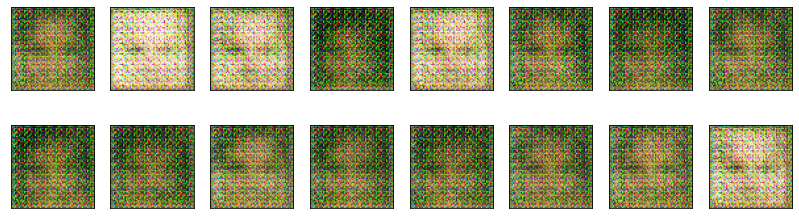

2024-03-30 14:58:58 | Epoch [2/10] | Batch 0/509 | lambda x gp: 0.0024 | d_loss: 1.5372 | g_loss: 0.7385
2024-03-30 15:06:08 | Epoch [2/10] | Batch 50/509 | lambda x gp: 0.0004 | d_loss: 1.5135 | g_loss: 0.7765
2024-03-30 15:13:19 | Epoch [2/10] | Batch 100/509 | lambda x gp: 0.0331 | d_loss: 1.6282 | g_loss: 0.8068
2024-03-30 15:20:26 | Epoch [2/10] | Batch 150/509 | lambda x gp: 0.0 | d_loss: 1.4176 | g_loss: 0.8105
2024-03-30 15:27:35 | Epoch [2/10] | Batch 200/509 | lambda x gp: 0.0004 | d_loss: 1.5038 | g_loss: 0.7749
2024-03-30 15:34:46 | Epoch [2/10] | Batch 250/509 | lambda x gp: 0.0623 | d_loss: 1.484 | g_loss: 0.7433
2024-03-30 15:41:56 | Epoch [2/10] | Batch 300/509 | lambda x gp: 0.0274 | d_loss: 1.5592 | g_loss: 0.7006
2024-03-30 15:49:03 | Epoch [2/10] | Batch 350/509 | lambda x gp: 0.0001 | d_loss: 1.5857 | g_loss: 0.7011
2024-03-30 15:56:11 | Epoch [2/10] | Batch 400/509 | lambda x gp: 0.0155 | d_loss: 1.6025 | g_loss: 0.7192
2024-03-30 16:03:22 | Epoch [2/10] | Batch 4

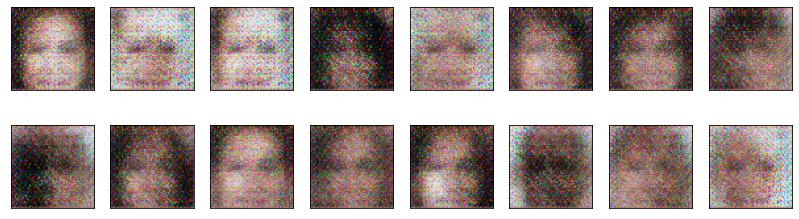

2024-03-30 16:11:54 | Epoch [3/10] | Batch 0/509 | lambda x gp: 0.0084 | d_loss: 1.5013 | g_loss: 0.7378
2024-03-30 16:19:02 | Epoch [3/10] | Batch 50/509 | lambda x gp: 0.0004 | d_loss: 1.4999 | g_loss: 0.7334
2024-03-30 16:26:28 | Epoch [3/10] | Batch 100/509 | lambda x gp: 0.0187 | d_loss: 1.5324 | g_loss: 0.7222
2024-03-30 16:33:37 | Epoch [3/10] | Batch 150/509 | lambda x gp: 0.0113 | d_loss: 1.5166 | g_loss: 0.7352
2024-03-30 16:40:44 | Epoch [3/10] | Batch 200/509 | lambda x gp: 0.0704 | d_loss: 1.5727 | g_loss: 0.7614
2024-03-30 16:47:48 | Epoch [3/10] | Batch 250/509 | lambda x gp: 0.0004 | d_loss: 1.461 | g_loss: 0.8159
2024-03-30 16:54:54 | Epoch [3/10] | Batch 300/509 | lambda x gp: 0.006 | d_loss: 1.5333 | g_loss: 0.7457
2024-03-30 17:02:01 | Epoch [3/10] | Batch 350/509 | lambda x gp: 0.0205 | d_loss: 1.5133 | g_loss: 0.7676
2024-03-30 17:09:05 | Epoch [3/10] | Batch 400/509 | lambda x gp: 0.016 | d_loss: 1.4624 | g_loss: 0.7758
2024-03-30 17:16:11 | Epoch [3/10] | Batch 

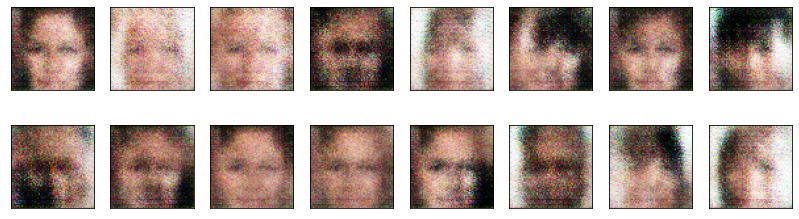

2024-03-30 17:24:33 | Epoch [4/10] | Batch 0/509 | lambda x gp: 0.0281 | d_loss: 1.5297 | g_loss: 0.7704
2024-03-30 17:31:44 | Epoch [4/10] | Batch 50/509 | lambda x gp: 0.0287 | d_loss: 1.5168 | g_loss: 0.76
2024-03-30 17:38:54 | Epoch [4/10] | Batch 100/509 | lambda x gp: 0.0002 | d_loss: 1.4708 | g_loss: 0.7828
2024-03-30 17:46:15 | Epoch [4/10] | Batch 150/509 | lambda x gp: 0.0666 | d_loss: 1.5581 | g_loss: 0.7942
2024-03-30 17:53:31 | Epoch [4/10] | Batch 200/509 | lambda x gp: 0.0 | d_loss: 1.4373 | g_loss: 0.7641
2024-03-30 18:00:43 | Epoch [4/10] | Batch 250/509 | lambda x gp: 0.0009 | d_loss: 1.4305 | g_loss: 0.7721
2024-03-30 18:08:08 | Epoch [4/10] | Batch 300/509 | lambda x gp: 0.0004 | d_loss: 1.4729 | g_loss: 0.7438
2024-03-30 18:15:35 | Epoch [4/10] | Batch 350/509 | lambda x gp: 0.0399 | d_loss: 1.5663 | g_loss: 0.7577
2024-03-30 18:22:54 | Epoch [4/10] | Batch 400/509 | lambda x gp: 0.0004 | d_loss: 1.4713 | g_loss: 0.7587
2024-03-30 18:30:04 | Epoch [4/10] | Batch 45

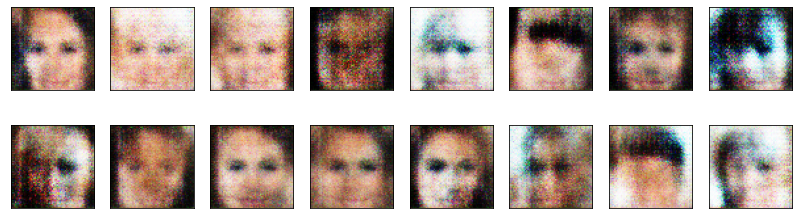

2024-03-30 18:38:49 | Epoch [5/10] | Batch 0/509 | lambda x gp: 0.0281 | d_loss: 1.5179 | g_loss: 0.7692
2024-03-30 18:46:06 | Epoch [5/10] | Batch 50/509 | lambda x gp: 0.0173 | d_loss: 1.5006 | g_loss: 0.7461
2024-03-30 18:53:22 | Epoch [5/10] | Batch 100/509 | lambda x gp: 0.0152 | d_loss: 1.4494 | g_loss: 0.7952
2024-03-30 19:00:39 | Epoch [5/10] | Batch 150/509 | lambda x gp: 0.0005 | d_loss: 1.4467 | g_loss: 0.7989
2024-03-30 19:07:54 | Epoch [5/10] | Batch 200/509 | lambda x gp: 0.0039 | d_loss: 1.4192 | g_loss: 0.7725
2024-03-30 19:15:17 | Epoch [5/10] | Batch 250/509 | lambda x gp: 0.0037 | d_loss: 1.4234 | g_loss: 0.7722
2024-03-30 19:22:41 | Epoch [5/10] | Batch 300/509 | lambda x gp: 0.0127 | d_loss: 1.4187 | g_loss: 0.7529
2024-03-30 19:30:04 | Epoch [5/10] | Batch 350/509 | lambda x gp: 0.017 | d_loss: 1.454 | g_loss: 0.7684
2024-03-30 19:37:25 | Epoch [5/10] | Batch 400/509 | lambda x gp: 0.0005 | d_loss: 1.4002 | g_loss: 0.7897
2024-03-30 19:44:38 | Epoch [5/10] | Batch

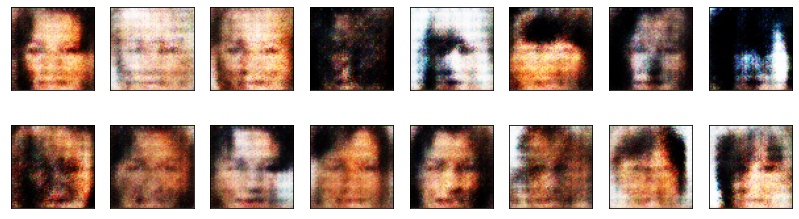

2024-03-30 19:53:06 | Epoch [6/10] | Batch 0/509 | lambda x gp: 0.0003 | d_loss: 1.4403 | g_loss: 0.7746
2024-03-30 20:00:24 | Epoch [6/10] | Batch 50/509 | lambda x gp: 0.0 | d_loss: 1.4327 | g_loss: 0.7357
2024-03-30 20:07:37 | Epoch [6/10] | Batch 100/509 | lambda x gp: 0.0103 | d_loss: 1.4405 | g_loss: 0.7753
2024-03-30 20:14:47 | Epoch [6/10] | Batch 150/509 | lambda x gp: 0.0122 | d_loss: 1.4726 | g_loss: 0.7905
2024-03-30 20:21:57 | Epoch [6/10] | Batch 200/509 | lambda x gp: 0.0009 | d_loss: 1.4585 | g_loss: 0.79
2024-03-30 20:29:08 | Epoch [6/10] | Batch 250/509 | lambda x gp: 0.0148 | d_loss: 1.4629 | g_loss: 0.7943
2024-03-30 20:36:18 | Epoch [6/10] | Batch 300/509 | lambda x gp: 0.0012 | d_loss: 1.4382 | g_loss: 0.7927
2024-03-30 20:43:22 | Epoch [6/10] | Batch 350/509 | lambda x gp: 0.0306 | d_loss: 1.455 | g_loss: 0.7578
2024-03-30 20:50:28 | Epoch [6/10] | Batch 400/509 | lambda x gp: 0.0928 | d_loss: 1.4982 | g_loss: 0.8024
2024-03-30 20:57:31 | Epoch [6/10] | Batch 450

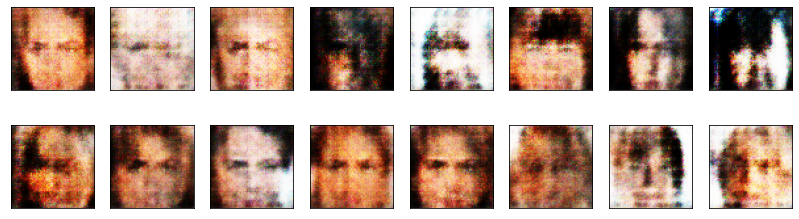

2024-03-30 21:05:54 | Epoch [7/10] | Batch 0/509 | lambda x gp: 0.0244 | d_loss: 1.4434 | g_loss: 0.7801
2024-03-30 21:13:07 | Epoch [7/10] | Batch 50/509 | lambda x gp: 0.0029 | d_loss: 1.4334 | g_loss: 0.7933
2024-03-30 21:20:24 | Epoch [7/10] | Batch 100/509 | lambda x gp: 0.0006 | d_loss: 1.4158 | g_loss: 0.7431
2024-03-30 21:27:40 | Epoch [7/10] | Batch 150/509 | lambda x gp: 0.0077 | d_loss: 1.3917 | g_loss: 0.786
2024-03-30 21:34:51 | Epoch [7/10] | Batch 200/509 | lambda x gp: 0.044 | d_loss: 1.4516 | g_loss: 0.7824
2024-03-30 21:41:56 | Epoch [7/10] | Batch 250/509 | lambda x gp: 0.0056 | d_loss: 1.4309 | g_loss: 0.7541
2024-03-30 21:48:55 | Epoch [7/10] | Batch 300/509 | lambda x gp: 0.008 | d_loss: 1.3795 | g_loss: 0.8038
2024-03-30 21:55:54 | Epoch [7/10] | Batch 350/509 | lambda x gp: 0.0433 | d_loss: 1.4427 | g_loss: 0.8258
2024-03-30 22:02:54 | Epoch [7/10] | Batch 400/509 | lambda x gp: 0.0355 | d_loss: 1.4537 | g_loss: 0.7925
2024-03-30 22:09:55 | Epoch [7/10] | Batch 

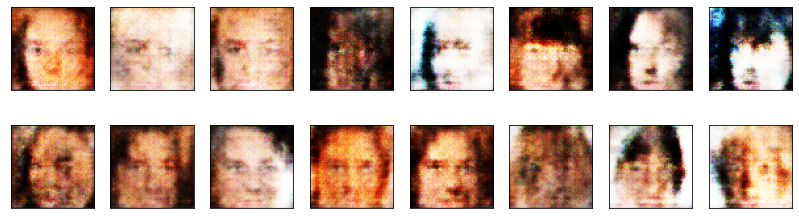

2024-03-30 22:18:11 | Epoch [8/10] | Batch 0/509 | lambda x gp: 0.0087 | d_loss: 1.4316 | g_loss: 0.7996
2024-03-30 22:25:14 | Epoch [8/10] | Batch 50/509 | lambda x gp: 0.0006 | d_loss: 1.3817 | g_loss: 0.7772
2024-03-30 22:32:12 | Epoch [8/10] | Batch 100/509 | lambda x gp: 0.0243 | d_loss: 1.4167 | g_loss: 0.7771
2024-03-30 22:39:10 | Epoch [8/10] | Batch 150/509 | lambda x gp: 0.0011 | d_loss: 1.3968 | g_loss: 0.7837
2024-03-30 22:46:06 | Epoch [8/10] | Batch 200/509 | lambda x gp: 0.0191 | d_loss: 1.4424 | g_loss: 0.815
2024-03-30 22:53:06 | Epoch [8/10] | Batch 250/509 | lambda x gp: 0.0019 | d_loss: 1.4613 | g_loss: 0.8051
2024-03-30 23:00:05 | Epoch [8/10] | Batch 300/509 | lambda x gp: 0.014 | d_loss: 1.4117 | g_loss: 0.7626
2024-03-30 23:07:03 | Epoch [8/10] | Batch 350/509 | lambda x gp: 0.0008 | d_loss: 1.3959 | g_loss: 0.8374
2024-03-30 23:14:01 | Epoch [8/10] | Batch 400/509 | lambda x gp: 0.0108 | d_loss: 1.4283 | g_loss: 0.7788
2024-03-30 23:20:59 | Epoch [8/10] | Batch

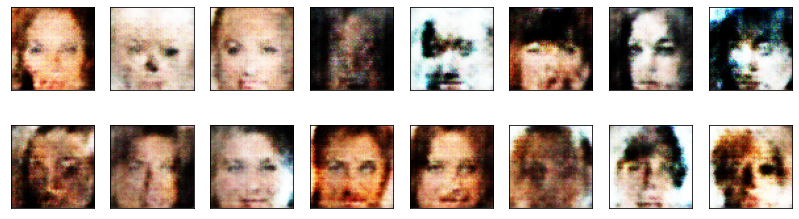

2024-03-30 23:29:11 | Epoch [9/10] | Batch 0/509 | lambda x gp: 0.001 | d_loss: 1.4192 | g_loss: 0.8212
2024-03-30 23:36:23 | Epoch [9/10] | Batch 50/509 | lambda x gp: 0.036 | d_loss: 1.4381 | g_loss: 0.8061
2024-03-30 23:43:23 | Epoch [9/10] | Batch 100/509 | lambda x gp: 0.0 | d_loss: 1.3877 | g_loss: 0.8264
2024-03-30 23:50:24 | Epoch [9/10] | Batch 150/509 | lambda x gp: 0.0046 | d_loss: 1.3883 | g_loss: 0.8154
2024-03-30 23:57:22 | Epoch [9/10] | Batch 200/509 | lambda x gp: 0.0229 | d_loss: 1.4368 | g_loss: 0.8079
2024-03-31 00:04:22 | Epoch [9/10] | Batch 250/509 | lambda x gp: 0.0169 | d_loss: 1.4155 | g_loss: 0.8153
2024-03-31 00:11:25 | Epoch [9/10] | Batch 300/509 | lambda x gp: 0.0114 | d_loss: 1.4332 | g_loss: 0.871
2024-03-31 00:18:32 | Epoch [9/10] | Batch 350/509 | lambda x gp: 0.0001 | d_loss: 1.3755 | g_loss: 0.8273
2024-03-31 00:25:52 | Epoch [9/10] | Batch 400/509 | lambda x gp: 0.0549 | d_loss: 1.4453 | g_loss: 0.805
2024-03-31 00:33:09 | Epoch [9/10] | Batch 450/

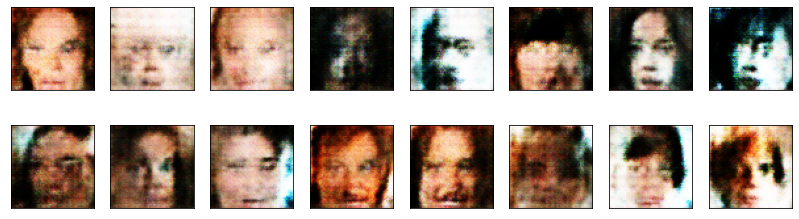

2024-03-31 00:41:47 | Epoch [10/10] | Batch 0/509 | lambda x gp: 0.0021 | d_loss: 1.3736 | g_loss: 0.8131
2024-03-31 00:49:05 | Epoch [10/10] | Batch 50/509 | lambda x gp: 0.0001 | d_loss: 1.3684 | g_loss: 0.8241
2024-03-31 00:56:22 | Epoch [10/10] | Batch 100/509 | lambda x gp: 0.0045 | d_loss: 1.3814 | g_loss: 0.8066
2024-03-31 01:03:42 | Epoch [10/10] | Batch 150/509 | lambda x gp: 0.0402 | d_loss: 1.457 | g_loss: 0.8161
2024-03-31 01:11:01 | Epoch [10/10] | Batch 200/509 | lambda x gp: 0.0043 | d_loss: 1.385 | g_loss: 0.7831
2024-03-31 01:18:17 | Epoch [10/10] | Batch 250/509 | lambda x gp: 0.0161 | d_loss: 1.4218 | g_loss: 0.8213
2024-03-31 01:25:32 | Epoch [10/10] | Batch 300/509 | lambda x gp: 0.0666 | d_loss: 1.4843 | g_loss: 0.7882
2024-03-31 01:32:49 | Epoch [10/10] | Batch 350/509 | lambda x gp: 0.0484 | d_loss: 1.4125 | g_loss: 0.7933
2024-03-31 01:40:00 | Epoch [10/10] | Batch 400/509 | lambda x gp: 0.0009 | d_loss: 1.4175 | g_loss: 0.8763
2024-03-31 01:47:19 | Epoch [10/1

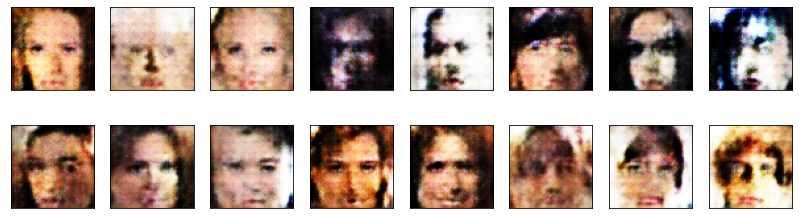

In [68]:
fixed_latent_vector = torch.randn(sample_size, latent_dim).float().to(device)
losses = []

for epoch in range(n_epochs):
    for batch_i, real_images in enumerate(dataloader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        
        if(batch_i % n_gen_batch_per_disc_batch == 0):
            d_loss = discriminator_step(batch_size, latent_dim, real_images, loss_type, gp_type) # train the discriminator
        if(batch_i % n_disc_batch_per_gen_batch == 0):
            g_loss = generator_step(batch_size, latent_dim, loss_type) # train the generator
        
        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            d = d_loss['loss'].item()
            g = g_loss['loss'].item()
            losses.append((d, g))
            gp = d_loss['gp'].item()
            
            # print discriminator and generator loss
            time = str(datetime.now()).split('.')[0]
            print("{} | Epoch [{}/{}] | Batch {}/{} | lambda x gp: {} | d_loss: {} | g_loss: {}".format(time, epoch+1, n_epochs, batch_i, len(dataloader), round(lambda_p*gp, 4), round(d,4), round(g,4)))
    
    # display images during training
    generator.eval()
    generated_images = generator(fixed_latent_vector)
    display(generated_images)
    generator.train()

### Training losses

Plot the training losses for the generator and discriminator.

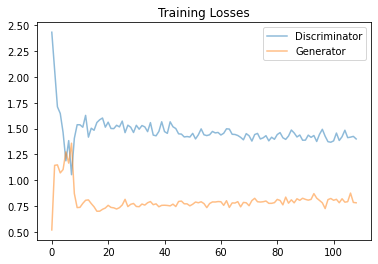

In [69]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0,1:], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1,1:], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result
* Loss functions

**Answer:**
* Generated samples resemble the dataset but it requires a lot of training on even simple models to get good generated samples.
* Larger models produce better images but take longer to train (obviously).
* For optimization, Adam gives good results and other strategies such as different learning rates for generator and discriminator, training generator (discriminator) more than discriminator (generator), etc. do not produce noticeable changes in generated images.
* BCE loss works well but Wasserstein loss does not produce very good images. Probably, Wasserstein loss requires more training. DRAGAN penalty works well with BCE but generated images with a slightly red tint. Images generated without gradient penalty have better color balance.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb".  

Submit the notebook using the ***SUBMIT*** button in the bottom right corner of the Project Workspace.